Решение задачи регрессии на датасете AB_NYC_2019, использование географических координат в качестве фичей
https://www.kaggle.com/code/whyalwaysme/ab-nyc-2019/input

In [1]:
!pip install osmnx
!pip install descartes

In [3]:
!unzip /content/AB_NYC_2019.csv.zip

Archive:  /content/AB_NYC_2019.csv.zip
  inflating: AB_NYC_2019.csv         


In [5]:
import osmnx  as ox
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from descartes import PolygonPatch

%matplotlib inline

In [4]:
df = pd.read_csv('/content/AB_NYC_2019.csv')
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


Подготовка данных

In [6]:
df = df[df['neighbourhood_group'] == 'Brooklyn']

In [7]:
df.drop(['neighbourhood_group'], axis=1, inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20104 entries, 0 to 48891
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20104 non-null  int64  
 1   name                            20098 non-null  object 
 2   host_id                         20104 non-null  int64  
 3   host_name                       20095 non-null  object 
 4   neighbourhood                   20104 non-null  object 
 5   latitude                        20104 non-null  float64
 6   longitude                       20104 non-null  float64
 7   room_type                       20104 non-null  object 
 8   price                           20104 non-null  int64  
 9   minimum_nights                  20104 non-null  int64  
 10  number_of_reviews               20104 non-null  int64  
 11  last_review                     16447 non-null  object 
 12  reviews_per_month               

In [10]:
len(df.id.unique())

20104

In [12]:
df.drop(['host_name', 'id', 'host_id', 'name', 'neighbourhood'], axis=1, inplace=True)

one hot encoding для room_type

In [13]:
df.room_type.unique()

array(['Private room', 'Entire home/apt', 'Shared room'], dtype=object)

In [16]:
ohe_room_t = pd.get_dummies(df.room_type)

In [17]:
df = df.join(ohe_room_t)

In [18]:
df.head()

,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,Entire home/apt,Private room,Shared room
0,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365,0,1,0
3,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194,1,0,0
6,40.68688,-73.95596,Private room,60,45,49,2017-10-05,0.40,1,0,0,1,0
12,40.66829,-73.98779,Private room,89,4,167,2019-06-24,1.34,3,314,0,1,0
15,40.70837,-73.95352,Entire home/apt,140,2,148,2019-06-29,1.20,1,46,1,0,0


In [19]:
df.drop(['room_type'], axis=1, inplace=True)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20104 entries, 0 to 48891
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   latitude                        20104 non-null  float64
 1   longitude                       20104 non-null  float64
 2   price                           20104 non-null  int64  
 3   minimum_nights                  20104 non-null  int64  
 4   number_of_reviews               20104 non-null  int64  
 5   last_review                     16447 non-null  object 
 6   reviews_per_month               16447 non-null  float64
 7   calculated_host_listings_count  20104 non-null  int64  
 8   availability_365                20104 non-null  int64  
 9   Entire home/apt                 20104 non-null  uint8  
 10  Private room                    20104 non-null  uint8  
 11  Shared room                     20104 non-null  uint8  
dtypes: float64(3), int64(5), object(

In [21]:
df[:25]

,latitude,longitude,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,Entire home/apt,Private room,Shared room
0,40.64749,-73.97237,149,1,9,2018-10-19,0.21,6,365,0,1,0
3,40.68514,-73.95976,89,1,270,2019-07-05,4.64,1,194,1,0,0
6,40.68688,-73.95596,60,45,49,2017-10-05,0.40,1,0,0,1,0
12,40.66829,-73.98779,89,4,167,2019-06-24,1.34,3,314,0,1,0
15,40.70837,-73.95352,140,2,148,2019-06-29,1.20,1,46,1,0,0
16,40.69169,-73.97185,215,2,198,2019-06-28,1.72,1,321,1,0,0
18,40.67592,-73.94694,99,3,53,2019-06-22,4.44,1,21,1,0,0
20,40.71842,-73.95718,299,3,9,2011-12-28,0.07,1,0,1,0,0
21,40.68069,-73.97706,130,2,130,2019-07-01,1.09,6,347,0,1,0
22,40.67989,-73.97798,80,1,39,2019-01-01,0.37,6,364,0,1,0


In [22]:
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)

In [27]:
import datetime

In [31]:
date_now = datetime.datetime(2019, 7, 10)

In [34]:
df['last_review'] = df['last_review'].fillna(date_now.strftime('%Y-%m-%d'))
df[:25]

,latitude,longitude,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,Entire home/apt,Private room,Shared room
0,40.64749,-73.97237,149,1,9,2018-10-19,0.21,6,365,0,1,0
3,40.68514,-73.95976,89,1,270,2019-07-05,4.64,1,194,1,0,0
6,40.68688,-73.95596,60,45,49,2017-10-05,0.40,1,0,0,1,0
12,40.66829,-73.98779,89,4,167,2019-06-24,1.34,3,314,0,1,0
15,40.70837,-73.95352,140,2,148,2019-06-29,1.20,1,46,1,0,0
16,40.69169,-73.97185,215,2,198,2019-06-28,1.72,1,321,1,0,0
18,40.67592,-73.94694,99,3,53,2019-06-22,4.44,1,21,1,0,0
20,40.71842,-73.95718,299,3,9,2011-12-28,0.07,1,0,1,0,0
21,40.68069,-73.97706,130,2,130,2019-07-01,1.09,6,347,0,1,0
22,40.67989,-73.97798,80,1,39,2019-01-01,0.37,6,364,0,1,0


In [39]:
df['last_review'] = df['last_review'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

In [40]:
df['days_from_last_review'] = df['last_review'].apply(lambda x: (date_now - x).days)

In [41]:
df['days_from_last_review'].describe()
# 25%          8.000000
# 50%         31.000000
# 75%        282.000000

count    20104.000000
mean       235.014922
std        394.325437
min          0.000000
25%          8.000000
50%         31.000000
75%        282.000000
max       3026.000000
Name: days_from_last_review, dtype: float64

In [48]:
def days_from_last_review_to_category(days):
  if days == 0: return 0
  elif days < 8: return 1
  elif days < 31: return 2
  elif days < 282: return 3
  else: return 4

In [50]:
df['category_last_review'] = df['days_from_last_review'].apply(days_from_last_review_to_category)

OHE

In [ ]:
df = df.join(pd.get_dummies(df.category_last_review))

In [53]:
df[:10]

,latitude,longitude,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,Entire home/apt,Private room,Shared room,days_from_last_review,category_last_review,0,1,2,3,4
0,40.64749,-73.97237,149,1,9,2018-10-19,0.21,6,365,0,1,0,264,3,0,0,0,1,0
3,40.68514,-73.95976,89,1,270,2019-07-05,4.64,1,194,1,0,0,5,1,0,1,0,0,0
6,40.68688,-73.95596,60,45,49,2017-10-05,0.40,1,0,0,1,0,643,4,0,0,0,0,1
12,40.66829,-73.98779,89,4,167,2019-06-24,1.34,3,314,0,1,0,16,2,0,0,1,0,0
15,40.70837,-73.95352,140,2,148,2019-06-29,1.20,1,46,1,0,0,11,2,0,0,1,0,0
16,40.69169,-73.97185,215,2,198,2019-06-28,1.72,1,321,1,0,0,12,2,0,0,1,0,0
18,40.67592,-73.94694,99,3,53,2019-06-22,4.44,1,21,1,0,0,18,2,0,0,1,0,0
20,40.71842,-73.95718,299,3,9,2011-12-28,0.07,1,0,1,0,0,2751,4,0,0,0,0,1
21,40.68069,-73.97706,130,2,130,2019-07-01,1.09,6,347,0,1,0,9,2,0,0,1,0,0
22,40.67989,-73.97798,80,1,39,2019-01-01,0.37,6,364,0,1,0,190,3,0,0,0,1,0


In [54]:
df.drop(['category_last_review', 'days_from_last_review', 'last_review'], axis=1, inplace=True)

In [55]:
df['is_available'] = df['availability_365'].apply(lambda x: 1 if x > 0 else 0)
df.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Entire home/apt,Private room,Shared room,0,1,2,3,4,is_available
0,40.64749,-73.97237,149,1,9,0.21,6,365,0,1,0,0,0,0,1,0,1
3,40.68514,-73.95976,89,1,270,4.64,1,194,1,0,0,0,1,0,0,0,1
6,40.68688,-73.95596,60,45,49,0.40,1,0,0,1,0,0,0,0,0,1,0
12,40.66829,-73.98779,89,4,167,1.34,3,314,0,1,0,0,0,1,0,0,1
15,40.70837,-73.95352,140,2,148,1.20,1,46,1,0,0,0,0,1,0,0,1


Используем latitude	longitude как фичи

In [57]:
#Загружаем пешеходный граф для Brooklyn
G = ox.graph_from_place('Brooklyn, New York, USA', network_type='walk')

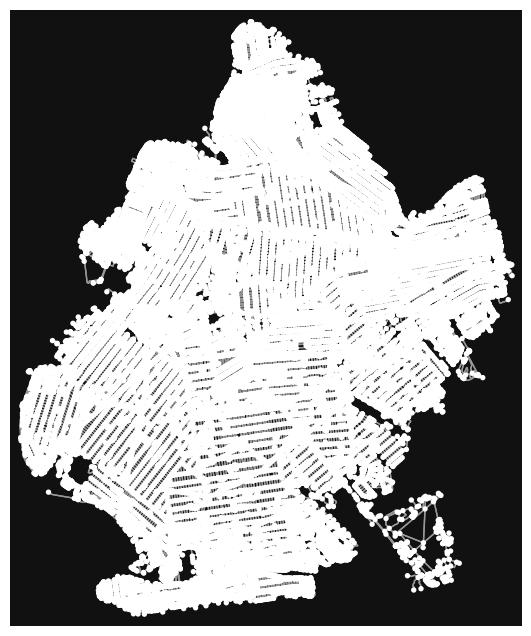

In [58]:
fig, ax = ox.plot_graph(G)

Координаты моста

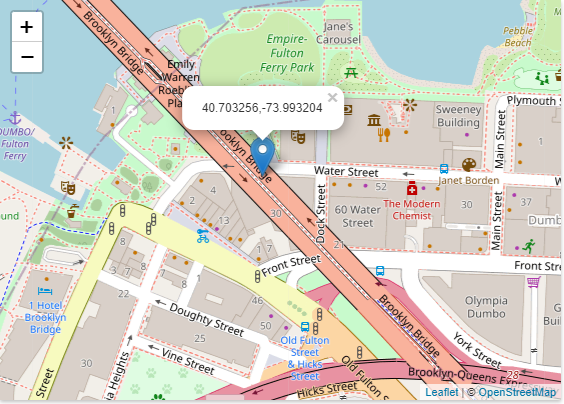

In [59]:
lat_center = 40.703256
lon_center = -73.993204

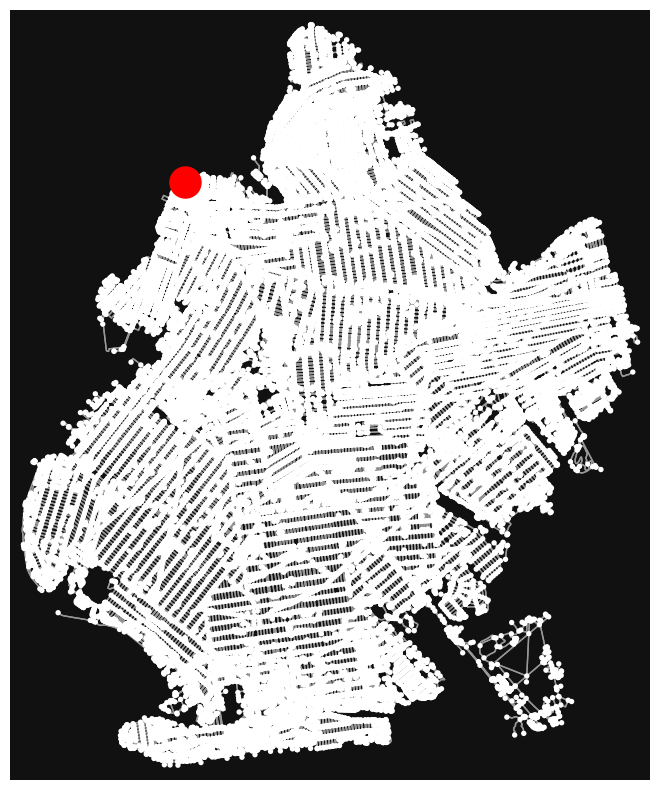

In [63]:
fig, ax = ox.plot_graph(G, figsize=(10,10),
                        show=False, close=False)
ax.scatter(lon_center, lat_center, c='red', s=500)
plt.show()

Карта пешей доступности

In [64]:
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

In [65]:
trip_times = [15, 30, 45, 60]
travel_speed = 4.5

meters_per_minute = travel_speed * 1000 / 60 #км в час → м в минуту
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

In [151]:
center_point = lat_center, lon_center

In [117]:
center_node = ox.nearest_nodes(G, center_point[1], center_point[0])

In [118]:
from shapely.geometry import Point, LineString, Polygon
import geopandas as gpd

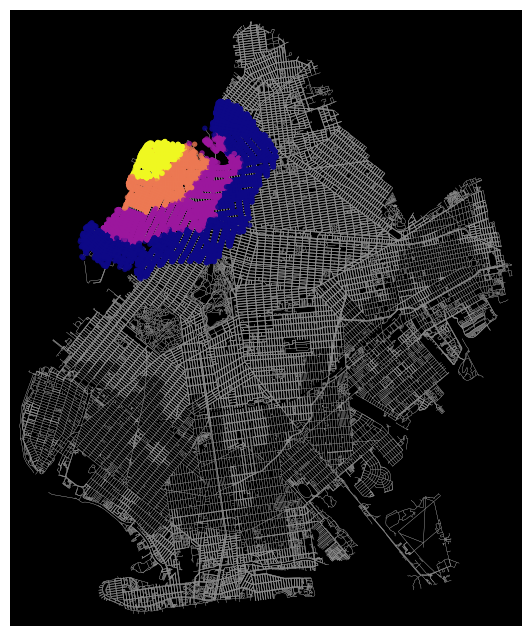

In [119]:
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [15 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2,
                        bgcolor='k', edge_linewidth=0.2, edge_color='#999999')


In [129]:
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    node_points = [Point((data['y'], data['x'])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)

In [130]:
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='plasma', start=0, return_hex=True)

In [131]:
isochrone_polys

[<POLYGON ((40.677 -74.019, 40.672 -74.019, 40.672 -74.018, 40.67 -74.01, 40....>,
 <POLYGON ((40.68 -74.011, 40.679 -74.01, 40.678 -74.006, 40.678 -74.006, 40....>,
 <POLYGON ((40.686 -74.003, 40.686 -74.002, 40.686 -74.002, 40.686 -74.002, 4...>,
 <POLYGON ((40.696 -73.999, 40.695 -73.998, 40.695 -73.994, 40.695 -73.991, 4...>]

In [135]:
import folium

# Создание карты
m = folium.Map(location=center_point, zoom_start=100)

folium.Marker(location=center_point, popup='Center', icon=folium.Icon(color='red')).add_to(m)

# Пройтись по списку полигонов
for i, polygon in enumerate(isochrone_polys):

    # Получить координаты полигона
    coordinates = list(polygon.exterior.coords)

    # Создать FeatureGroup для каждого полигона
    fg = folium.FeatureGroup(name=f"Polygon {i+1}")

    # Добавить полигон в FeatureGroup
    folium.PolyLine(locations=coordinates, color='black', fill_color=iso_colors[i], fill_opacity=0.5).add_to(fg)

    # Добавить FeatureGroup на карту
    fg.add_to(m)

# Добавить слой для управления FeatureGroup
folium.LayerControl().add_to(m)

# Отобразить карту
m

Результат

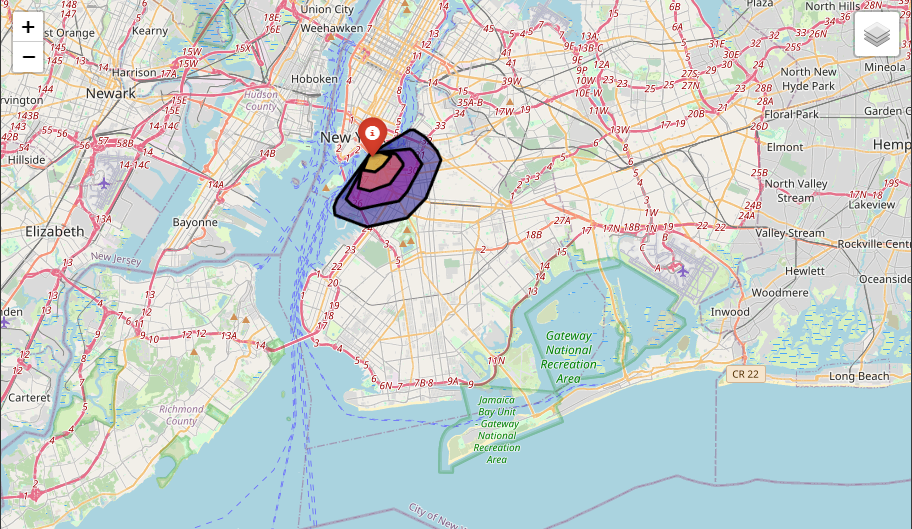

Формирование фичи

In [172]:
#Найдем вершины графа, соотвествующие координамтам датасета
%time nearest_edges = ox.nearest_nodes(G, df['longitude'], df['latitude'])

CPU times: user 1.77 s, sys: 7.91 ms, total: 1.78 s
Wall time: 1.94 s


In [189]:
nearest_edge_center = ox.nearest_nodes(G, center_point[1], center_point [0])

In [190]:
nearest_edge_center

7314517990

In [192]:
 #найдем длину путей от всех квартир до выбранной точки
route_lengths = []
for i in range(len(df)):
    route = nx.shortest_path(G, nearest_edge_center, nearest_edges[i])
    route_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route, 'length')))
    route_lengths.append(route_length)


<ipython-input-192-e7369eeeb435>:5: UserWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in a future release. Use the `route_to_gdf` function instead.
  route_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route, 'length')))


Передположим, что пешая доступность - это все, что в пределах 3-й зоны, то есть в 45 минутах хотьбы

4500*0,75 = 3375

In [193]:
df['route_lengths'] = route_lengths

In [194]:
df['get_on_foot'] = df['route_lengths'].apply(lambda x: 1 if x < 3375 else 0)

In [195]:
df.drop(['route_lengths','latitude', 'longitude'], axis=1, inplace=True)

In [199]:
df.head()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Entire home/apt,Private room,Shared room,0,1,2,3,4,is_available,get_on_foot
0,149,1,9,0.21,6,365,0,1,0,0,0,0,1,0,1,0
3,89,1,270,4.64,1,194,1,0,0,0,1,0,0,0,1,0
6,60,45,49,0.40,1,0,0,1,0,0,0,0,0,1,0,0
12,89,4,167,1.34,3,314,0,1,0,0,0,1,0,0,1,0
15,140,2,148,1.20,1,46,1,0,0,0,0,1,0,0,1,0


baseline модель

In [200]:
y = df['price'] + 0.001
X = df.drop(['price'], axis=1)

In [201]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Нормировка

In [203]:
from sklearn.preprocessing import StandardScaler

In [204]:
scaler = StandardScaler()
list_to_norm = ['minimum_nights','number_of_reviews','reviews_per_month', 'calculated_host_listings_count', 'availability_365']
list_binary_features = ['Entire home/apt', 'Private room', 'Shared room', 0, 1, 2, 3, 4, 'is_available', 'get_on_foot']

In [205]:
# Отделяем, что нормировать
X_train_to_norm = X_train[list_to_norm]
X_test_to_norm = X_test[list_to_norm]

# Нормируем, что нормируется
X_train_to_norm = scaler.fit_transform(X_train_to_norm)
X_test_to_norm = scaler.transform(X_test_to_norm)

# Конкатенируем с бинарными
X_train = np.c_[X_train_to_norm, np.array(X_train[list_binary_features])]
X_test = np.c_[X_test_to_norm, np.array(X_test[list_binary_features])]

# Логорифмируем таргет
y_train_log = np.array(np.log(y_train))
y_test_log = np.array(np.log(y_test))

In [206]:
print(X_train.shape,X_test.shape, y_train_log.shape,y_test_log.shape)

(16083, 15) (4021, 15) (16083,) (4021,)


In [207]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train_log)

In [208]:
y_predict = reg.predict(X_test)

In [209]:
y_predict_exp = np.exp(y_predict).reshape((y_predict.shape[0],))

In [210]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
y_test_numpy = np.array(y_test)

In [211]:
N1 = 0
N2 = 30
print(np.c_[y_predict_exp[N1:N2], y_test_numpy[N1:N2]])

[[158.927 200.001]
 [134.081 89.001]
 [147.997 195.001]
 [67.131 51.001]
 [67.371 103.001]
 [68.031 125.001]
 [60.279 50.001]
 [139.999 150.001]
 [62.177 90.001]
 [39.897 40.001]
 [61.047 50.001]
 [137.155 105.001]
 [75.839 75.001]
 [149.037 129.001]
 [83.297 40.001]
 [170.169 75.001]
 [69.755 70.001]
 [148.895 196.001]
 [150.927 200.001]
 [57.197 80.001]
 [140.517 199.001]
 [140.129 129.001]
 [135.908 179.001]
 [74.002 49.001]
 [59.049 50.001]
 [73.299 55.001]
 [140.390 65.001]
 [140.105 70.001]
 [141.222 160.001]
 [60.746 55.001]]


In [212]:
# Выведем значение метрики MAE (средее абсолютная ошибка)
from sklearn.metrics import mean_absolute_error
print(f'MAE: {mean_absolute_error(y_predict_exp, y_test_numpy)}')

MAE: 47.794659962941516


In [213]:
#Сделаем предсказание наивной моделью: зададим значения цен каждого объекта средним значением по всем ценам

y_mean = [y_test_numpy.mean() for _ in range(len(y_test_numpy))]


In [214]:
from sklearn.metrics import mean_absolute_error
print(f'MAE: {mean_absolute_error(y_mean, y_test_numpy)}')

MAE: 68.08270370656021
